'pip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
c:\Users\dongx\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\dongx\AppData\Local\Temp\ipykernel_35112\57743883.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2", ax=ax0)


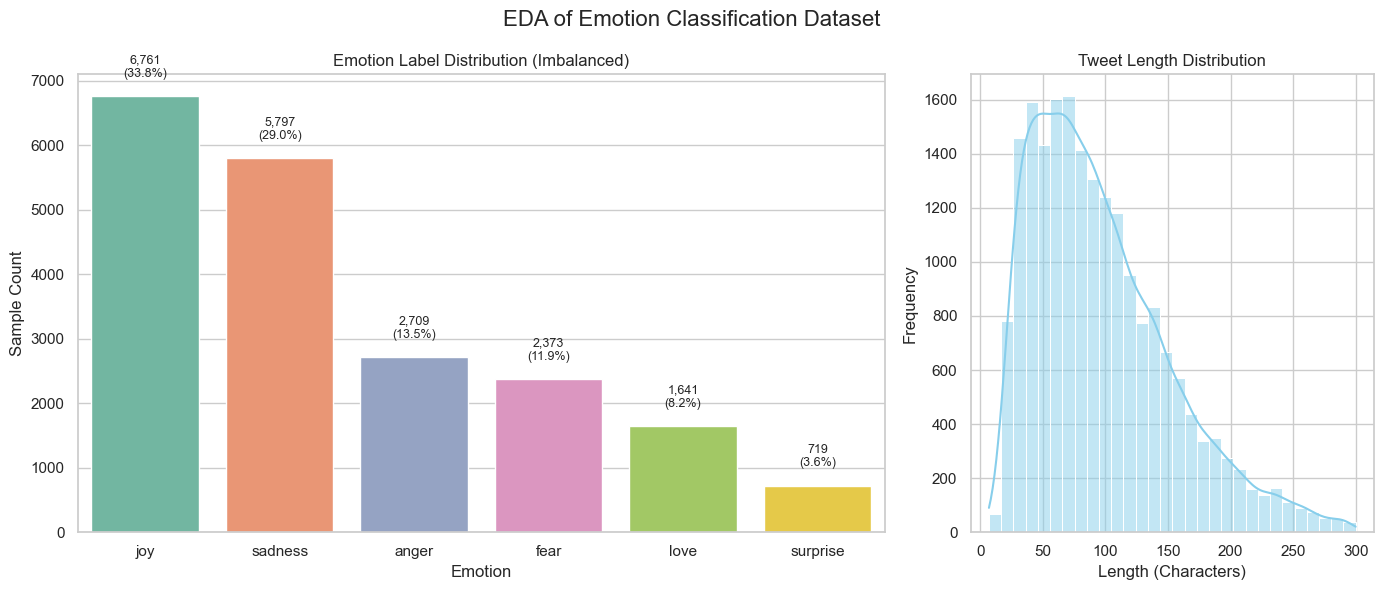

Emotion Class Counts:
 emotion
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

Class Imbalance Ratio (Max/Min): 9.40x

Text Length Stats:
 count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64

Missing Values:
 text           0
label          0
emotion        0
text_length    0
dtype: int64


In [1]:

!pip install huggingface_hub
from huggingface_hub import hf_hub_download

# Download the Parquet files from Hugging Face
hf_hub_download(repo_id="dair-ai/emotion", filename="split/train-00000-of-00001.parquet", repo_type="dataset", local_dir=".")
hf_hub_download(repo_id="dair-ai/emotion", filename="split/test-00000-of-00001.parquet", repo_type="dataset", local_dir=".")
hf_hub_download(repo_id="dair-ai/emotion", filename="split/validation-00000-of-00001.parquet", repo_type="dataset", local_dir=".")

# Rename the files for consistency with the rest of the code
import os
os.rename("split/train-00000-of-00001.parquet", "train.parquet")
os.rename("split/test-00000-of-00001.parquet", "test.parquet")
os.rename("split/validation-00000-of-00001.parquet", "validation.parquet")

# Create the tokenizer directory
!mkdir -p tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
tokenizer.save_pretrained("tokenizer")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


train_df = pd.read_parquet("train.parquet")
val_df = pd.read_parquet("validation.parquet")
test_df = pd.read_parquet("test.parquet")


df = pd.concat([train_df, val_df, test_df], ignore_index=True)


label2int = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}
int2label = {v: k for k, v in label2int.items()}
df["emotion"] = df["label"].map(int2label)


label_counts = df["emotion"].value_counts().sort_values(ascending=False)
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count


df["text_length"] = df["text"].apply(len)
length_stats = df["text_length"].describe()


missing = df.isnull().sum()


import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

ax0 = plt.subplot(gs[0])
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2", ax=ax0)
ax0.set_title("Emotion Label Distribution (Imbalanced)")
ax0.set_ylabel("Sample Count")
ax0.set_xlabel("Emotion")
total = label_counts.sum()
for i, count in enumerate(label_counts.values):
    percent = count / total * 100
    ax0.text(i, count + 300, f"{count:,}\n({percent:.1f}%)", ha="center", fontsize=9)

ax1 = plt.subplot(gs[1])
sns.histplot(df["text_length"], bins=30, kde=True, color="skyblue", ax=ax1)
ax1.set_title("Tweet Length Distribution")
ax1.set_xlabel("Length (Characters)")
ax1.set_ylabel("Frequency")

plt.suptitle("EDA of Emotion Classification Dataset", fontsize=16)
plt.tight_layout()
plt.show()

print("Emotion Class Counts:\n", label_counts)
print(f"\nClass Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}x")
print("\nText Length Stats:\n", length_stats)
print("\nMissing Values:\n", missing)
